In [1]:
import dataclasses
import functools
import itertools

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import KetSugar as ks
import MaxLik as ml


butterfly = lambda x: ks.ketbra(x, x)

samplings = np.load('probes_samplings.npz')
SAMPLING_KEY = 'n30'
cal_sampl = samplings[SAMPLING_KEY]
test_sampl = samplings['n108']

cal_states = np.array([ks.BlochKet(theta, phi) for theta, phi in cal_sampl])
test_states = np.array([ks.BlochKet(theta, phi) for theta, phi in test_sampl])

SX = np.array([0,1,1,0]).reshape((2,2))
SZ = np.array([1,0,0,-1]).reshape((2,2))

def apply_noise(rho_in, p_x=0.0, p_z=0.0): 
    rho_x = ks.ApplyOp(rho_in, SX)
    rho_bit_flipped = p_x*rho_x/2 + (1-p_x/2)*rho_in
    rho_phase_flipped = (1-p_z/2)*rho_bit_flipped + p_z*ks.ApplyOp(rho_bit_flipped, SZ)/2
    return rho_phase_flipped

# noisy_cal_rhos = np.array([apply_noise(butterfly(ket)) for ket in cal_states])

MaxLik: Numba Allowed: True => use cycle-based K-vector construction


In [2]:
rotations_tomo_proj = np.array((
    (0,0),
    (np.pi,0),
    (np.pi/2, 0),
    (np.pi/2, np.pi),
    (np.pi/2, 1*np.pi/2),
    (np.pi/2, 3*np.pi/2)
))


# def get_assumed_rpv(errors):
#     coords = rotations_tomo_proj + errors.reshape((6,2))
#     coss = np.cos(coords[:,0]/2)
#     sins = np.sin(coords[:,0]/2)
#     exps = np.exp(1j*coords[:,1])
#     pis = np.zeros((6,2,1), dtype=np.complex128)
#     pis[:,0,0] = coss
#     pis[:,1,0] = sins*exps
#     return np.einsum('ki,kj->kij', pis.reshape((-1,2)), pis.conj().reshape((-1,2)))

def get_assumed_rpv(errors):
    coords = rotations_tomo_proj + errors.reshape((6,2))
    proj_kets = [ks.BlochKet(theta, phi) for theta, phi in coords]
    return np.array([ket @ ket.T.conjugate() for ket in proj_kets])

def simulate_tomograms_pc_noiseless(probes_coord, errors, noise_x=0.0, noise_y=0.0):
    tomograms = []
    noise = 0.001 #in the sense of overall uniform purity drop
    rpv_true = get_assumed_rpv(errors)
    for theta, phi in probes_coord:
        probe_ket = ks.BlochKet(theta, phi)
        probe_rho = ks.ketbra(probe_ket, probe_ket)
        probe_rho_noisy = apply_noise(probe_rho, noise_x, noise_y)                
        tomogram = np.array([ks.Overlap(probe_rho_noisy, proj).real for proj in rpv_true])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    return tomograms


In [3]:
def dominant_eigenvector(rho):
    _, evec = np.linalg.eigh(rho)
    return evec[:,-1].reshape((2,1))

def ket_to_bloch_vec(ket):
    if ket[0,0] == 0:
        return (0,0,-1)
    elif ket[1,0] == 0:
        return (0, 0, 1)        
    phi = np.angle(ket[1,0])-np.angle(ket[0,0])
    phi = np.angle(np.exp(1j*phi))
    theta = np.arccos(np.abs(ket[0,0]))*2
    z = np.cos(theta)
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    return np.array((x,y,z))

def get_respective_angles(rhos, index1, index2):
    evecs = np.array([dominant_eigenvector(rho) for rho in rhos])
    ebloch = np.array([ket_to_bloch_vec(ket) for ket in evecs])
    refs = ebloch[[index1, index2]]
    ref_overlap = (refs[0,:] @ refs[1,:])
    if ref_overlap > 0.2:
        pass
        # print("Warning: reference states have significant overlap")
    deltas = np.arccos(np.clip(ebloch @ refs.T, -1, 1))
    return deltas

def angle_metric(rhos1, rhos2, index1, index2):
    delta = get_respective_angles(rhos1, index1, index2)
    epsilon = get_respective_angles(rhos2, index1, index2)
    return np.max(np.abs(delta - epsilon))



In [4]:
ML_ITERS = 100#00
ML_THR = 1e-7

def map_tomograms(tomos, pis):
    return np.array([ml.Reconstruct(t, pis, ML_ITERS, ML_THR, RhoPiVect = True, Renorm = True) for t in tomos])

@dataclasses.dataclass
class AnalysisData:
    pur_naive : np.ndarray
    pur_true  : np.ndarray
    pur_opt   : np.ndarray
    dev_mae_naive : np.ndarray
    dev_mae_true  : np.ndarray
    dev_mae_opt   : np.ndarray
    rhos_opt  : np.ndarray

@dataclasses.dataclass
class PostAnalysisData:
    nai_min_pur : float
    nai_ptp_pur : float
    tru_min_pur : float
    tru_ptp_pur : float    
    opt_min_pur : float
    opt_ptp_pur : float    
    #-----
    nai_max_dmae : float
    nai_mean_dmae : float
    tru_max_dmae : float
    tru_mean_dmae : float    
    opt_max_dmae : float
    opt_mean_dmae : float  


def postanalyze(analysis : AnalysisData):
    return PostAnalysisData(
        nai_min_pur = np.min(analysis.pur_naive),
        nai_ptp_pur = np.ptp(analysis.pur_naive),
        tru_min_pur = np.min(analysis.pur_true),
        tru_ptp_pur = np.ptp(analysis.pur_true),
        opt_min_pur = np.min(analysis.pur_opt),
        opt_ptp_pur = np.ptp(analysis.pur_opt),
        nai_max_dmae = np.max(analysis.dev_mae_naive),
        nai_mean_dmae = np.mean(analysis.dev_mae_naive),
        tru_max_dmae = np.max(analysis.dev_mae_true),
        tru_mean_dmae = np.mean(analysis.dev_mae_true),
        opt_max_dmae = np.max(analysis.dev_mae_opt),
        opt_mean_dmae = np.mean(analysis.dev_mae_opt)
    )

def preanalyze(tomos, optim_err, true_err, reference_kets, ref_indices, noises):    
    pi_opt = get_assumed_rpv(optim_err)
    pi_true = get_assumed_rpv(true_err)
    pi_naive = get_assumed_rpv(np.zeros(12))
    rho_opt = map_tomograms(tomos, pi_opt)
    rho_true = map_tomograms(tomos, pi_true)
    rho_naive = map_tomograms(tomos, pi_naive)
    #ideal matrices = noisy ideal states
    rho_ideal = np.array([apply_noise(butterfly(ket), *noises) for ket in reference_kets])
    
    purs_naive = np.array([ks.Purity(r).real for r in rho_naive])
    purs_true = np.array([ks.Purity(r).real for r in rho_true])
    purs_opt = np.array([ks.Purity(r).real for r in rho_opt])

    dev_mae_true = angle_metric(rho_true, rho_ideal, ref_indices[0], ref_indices[1])
    dev_mae_opt = angle_metric(rho_opt, rho_ideal, ref_indices[0], ref_indices[1])
    dev_mae_naive = angle_metric(rho_naive, rho_ideal, ref_indices[0], ref_indices[1])

    return AnalysisData(
        pur_naive = purs_naive,
        pur_true = purs_true,
        pur_opt = purs_opt,
        dev_mae_naive = dev_mae_naive,
        dev_mae_true = dev_mae_true,
        dev_mae_opt = dev_mae_opt,
        rhos_opt = rho_opt
    )

def generate_tests(reference_coords, pis, errors, noise_x=0.0, noise_y=0.0):
    tomograms = []
    noise = 0.001
    reference_kets = []
    tomograms = []
    noise = 0.001 #in the sense of overall uniform purity drop
    rpv_true = get_assumed_rpv(errors)
    for theta, phi in reference_coords:
        probe_ket = ks.BlochKet(theta, phi)
        reference_kets.append(probe_ket)
        probe_rho = ks.ketbra(probe_ket, probe_ket)        
        probe_rho_noisy = apply_noise(probe_rho, noise_x, noise_y)                
        tomogram = np.array([ks.Overlap(probe_rho_noisy, proj).real for proj in rpv_true])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    # return tomograms
    #return reference kets, without env noise
    #it will be added in preanalyze() 
    #the noises is took into account into ideal reference states
    return tomograms, np.array(reference_kets)

def analyze_tests(reference_coords, optim_err, true_err, ref_indices, noises):    
    pi_true = get_assumed_rpv(true_err)
    tomograms, reference_kets = generate_tests(reference_coords, pi_true, true_err, *noises)
    analyzed = preanalyze(tomograms, optim_err, true_err, reference_kets, ref_indices, noises)
    return analyzed

def analyze_data(input_data_file, output_data_file, noises):
    inp_datas = np.load(input_data_file)
    calibration_tomos = inp_datas['test_data']
    true_value = inp_datas['truths']
    opt_results = np.genfromtxt(output_data_file)
    opt_params = opt_results[:, 2:]
    n = min(calibration_tomos.shape[0], opt_results.shape[0])
    results = []
    for index in range(n):
        print(index, end='\r')
        calib_analysis = preanalyze(calibration_tomos[index], opt_params[index], true_value[index], cal_states, [1,12], noises)                
        test_analysis = analyze_tests(test_sampl, opt_params[index], true_value[index], [0,70], noises)
        post_calib_analysis = postanalyze(calib_analysis)
        post_test_analysis = postanalyze(test_analysis)
        results.append((post_calib_analysis, post_test_analysis))
    # print('.')
    return results

def analyze_bulk(results : list[PostAnalysisData]):
    print("Minimum purity:")
    nai_min_pur = np.array([(r_cal.nai_min_pur, r_test.nai_min_pur) for r_cal, r_test in results])
    mu_nai_min_pur = np.mean(nai_min_pur, axis=0)
    std_nai_min_pur = np.std(nai_min_pur, axis=0)

    print('Naive approach')
    print(f'Calib set: {mu_nai_min_pur[0]:.3e}+/-{std_nai_min_pur[0]:.3e}')
    print(f'Test set : {mu_nai_min_pur[1]:.3e}+/-{std_nai_min_pur[1]:.3e}')

    tru_min_pur = np.array([(r_cal.tru_min_pur , r_test.tru_min_pur) for r_cal, r_test in results])
    mu_tru_min_pur = np.mean(tru_min_pur, axis=0)
    std_tru_min_pur = np.std(tru_min_pur, axis=0)

    print('With true parameters')
    print(f'Calib set: {mu_tru_min_pur[0]:.3e}+/-{std_tru_min_pur[0]:.3e}')
    print(f'Test set : {mu_tru_min_pur[1]:.3e}+/-{std_tru_min_pur[1]:.3e}')

    opt_min_pur = np.array([(r_cal.opt_min_pur , r_test.opt_min_pur) for r_cal, r_test in results])
    mu_opt_min_pur = np.mean(opt_min_pur, axis=0)
    std_opt_min_pur = np.std(opt_min_pur, axis=0)

    print('With found parameters')
    print(f'Calib set: {mu_opt_min_pur[0]:.3e}+/-{std_opt_min_pur[0]:.3e}')
    print(f'Test set : {mu_opt_min_pur[1]:.3e}+/-{std_opt_min_pur[1]:.3e}')    

    print("\nMinimum fidelity:")
    nai_max_dmae = np.array([(r_cal.nai_max_dmae, r_test.nai_max_dmae) for r_cal, r_test in results])
    mu_nai_max_dmae = np.mean(nai_max_dmae, axis=0)
    std_nai_max_dmae = np.std(nai_max_dmae, axis=0)

    print('Naive approach')
    print(f'Calib set: {mu_nai_max_dmae[0]:.3e}+/-{std_nai_max_dmae[0]:.3e}')
    print(f'Test set : {mu_nai_max_dmae[1]:.3e}+/-{std_nai_max_dmae[1]:.3e}')

    tru_max_dmae = np.array([(r_cal.tru_max_dmae , r_test.tru_max_dmae) for r_cal, r_test in results])
    mu_tru_max_dmae = np.mean(tru_max_dmae, axis=0)
    std_tru_max_dmae = np.std(tru_max_dmae, axis=0)

    print('With true parameters')
    print(f'Calib set: {mu_tru_max_dmae[0]:.3e}+/-{std_tru_max_dmae[0]:.3e}')
    print(f'Test set : {mu_tru_max_dmae[1]:.3e}+/-{std_tru_max_dmae[1]:.3e}')

    opt_max_dmae = np.array([(r_cal.opt_max_dmae , r_test.opt_max_dmae) for r_cal, r_test in results])
    mu_opt_max_dmae = np.mean(opt_max_dmae, axis=0)
    std_opt_max_dmae = np.std(opt_max_dmae, axis=0)

    print('With found parameters')
    print(f'Calib set: {mu_opt_max_dmae[0]:.3e}+/-{std_opt_max_dmae[0]:.3e}')
    print(f'Test set : {mu_opt_max_dmae[1]:.3e}+/-{std_opt_max_dmae[1]:.3e}')

    return np.array(
        [[
        [mu_nai_min_pur, std_nai_min_pur],
        [mu_tru_min_pur, std_tru_min_pur],
        [mu_opt_min_pur, std_opt_min_pur]
        ],
        [
        [mu_nai_max_dmae, std_nai_max_dmae],
        [mu_tru_max_dmae, std_tru_max_dmae],
        [mu_opt_max_dmae, std_opt_max_dmae]
        ]])

# pur/fid, nai/tru/opt, cal/test, mean/std
    

In [5]:
print('ahojY')

ahojY


In [27]:
cnts_quantifier = '100k'
quants = ['0px_0pz', '1px_1pz','5px_5pz', '10px_10pz', '100px_100pz']
cnts = [(0, 0), (1e-3, 1e-3),(5e-3, 5e-3), (10e-3,10e-3), (100e-3,100e-3)]

results_collection = []
for cnt, qant in zip(cnts, quants):
    print(cnt, qant)
    r = analyze_bulk(analyze_data(f'inputs/test_data_{SAMPLING_KEY}_5sigma_{qant}.npz', f'outputs/output_test_data_{SAMPLING_KEY}_5sigma_{qant}.txt', cnt))
    results_collection.append(r)
results_collection = np.array(results_collection)

(0, 0) 0px_0pz
Minimum purity:
Naive approach
Calib set: 9.186e-01+/-2.340e-02
Test set : 9.141e-01+/-2.463e-02
With true parameters
Calib set: 9.934e-01+/-5.881e-04
Test set : 9.927e-01+/-5.459e-04
With found parameters
Calib set: 9.945e-01+/-5.101e-04
Test set : 9.934e-01+/-9.105e-04

Minimum fidelity:
Naive approach
Calib set: 1.167e-01+/-4.154e-02
Test set : 1.122e-01+/-4.364e-02
With true parameters
Calib set: 2.575e-03+/-3.040e-04
Test set : 2.444e-03+/-4.817e-04
With found parameters
Calib set: 5.309e-03+/-3.837e-03
Test set : 5.298e-03+/-3.003e-03
(0.001, 0.001) 1px_1pz
Minimum purity:
Naive approach
Calib set: 9.161e-01+/-2.339e-02
Test set : 9.121e-01+/-2.455e-02
With true parameters
Calib set: 9.926e-01+/-5.611e-04
Test set : 9.919e-01+/-5.431e-04
With found parameters
Calib set: 9.936e-01+/-7.713e-04
Test set : 9.924e-01+/-1.592e-03

Minimum fidelity:
Naive approach
Calib set: 1.145e-01+/-3.974e-02
Test set : 1.121e-01+/-4.156e-02
With true parameters
Calib set: 2.193e-03+/

In [28]:
results_collection.shape

(5, 2, 3, 2, 2)

In [29]:
results_collection[0][0]

array([[[9.18553234e-01, 9.14069622e-01],
        [2.34011969e-02, 2.46318313e-02]],

       [[9.93441122e-01, 9.92724320e-01],
        [5.88145902e-04, 5.45945040e-04]],

       [[9.94494836e-01, 9.93427399e-01],
        [5.10080013e-04, 9.10478170e-04]]])

In [30]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})

In [31]:
results_collection.shape

(5, 2, 3, 2, 2)

['(0, 0)', '(1, 1)', '(5, 5)', '(10, 10)', '(100, 100)']


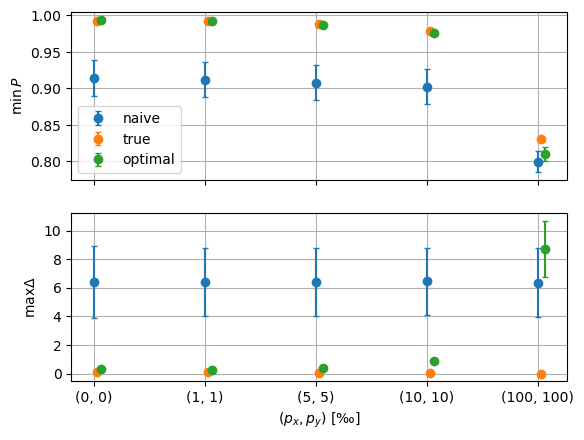

In [32]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
xax = np.arange(results_collection.shape[0])
xlab = [f'({prob_x*1e3:.0f}, {prob_z*1e3:.0f})' for prob_x, prob_z in cnts]
print(xlab)

ideg = 180/np.pi
for i, label in enumerate(('naive','true', 'optimal')):
    x_vis_offset = i/32
    ax1.errorbar(x = xax+x_vis_offset, y = results_collection[:, 0, i, 0, 1], yerr = results_collection[:, 0, i, 1, 1], fmt="o", label=label)
    # ax1.set_xscale('log')
    ax1.set_xticks(xax, labels=xlab, rotation='vertical')
ax1.legend()
ax1.grid()
ax1.set_ylabel('$\min\,P$')

for i, label in enumerate(('naive','true', 'optimal')):
    x_vis_offset = i/32
    ax2.errorbar(x = xax+x_vis_offset, y = ideg*results_collection[:, 1, i, 0, 1], yerr = ideg*results_collection[:, 1, i, 1, 1], fmt="o", label=label)
# ax2.legend()
ax2.set_xlabel('$(p_x, p_y)$ [‰]')
ax2.set_ylabel('$\max\Delta$')
ax2.grid()

plt.show()


['(0, 0)', '(1, 1)', '(5, 5)', '(10, 10)', '(100, 100)']


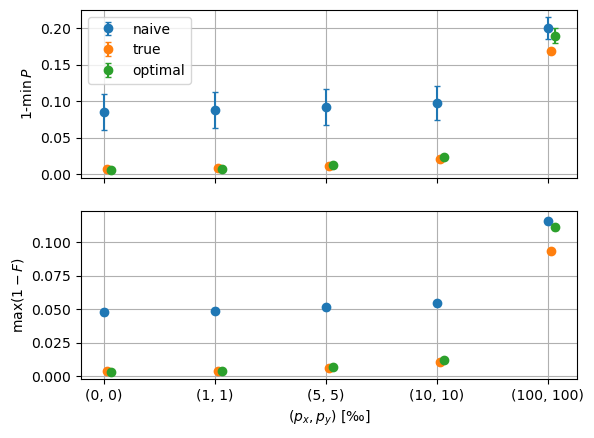

In [33]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
xax = np.arange(results_collection.shape[0])
xlab = [f'({prob_x*1e3:.0f}, {prob_z*1e3:.0f})' for prob_x, prob_z in cnts]
print(xlab)

ideg = 180/np.pi
for i, label in enumerate(('naive','true', 'optimal')):
    x_vis_offset = i/32
    y = 1 - results_collection[:, 0, i, 0, 1]
    dy = results_collection[:, 0, i, 1, 1]    
    ax1.errorbar(x = xax+x_vis_offset, y = y, yerr = dy, fmt="o", label=label)
    # ax1.set_xscale('log')
    ax1.set_xticks(xax, labels=xlab, rotation='vertical')
ax1.legend()
ax1.grid()
ax1.set_ylabel('1-$\min\,P$')

for i, label in enumerate(('naive','true', 'optimal')):
    x_vis_offset = i/32
    pur = results_collection[:, 0, i, 0, 1]
    pmix = np.sqrt(2*pur - 1)    
    yfi = np.cos(results_collection[:, 1, i, 0, 1]/2)**2    
    yfic = yfi*pmix + (1-pmix)/2
    yific = 1-yfic
    dyfi = np.cos(results_collection[:, 1, i, 0, 1]/2)*np.sin(results_collection[:, 1, i, 0, 1]/2)*results_collection[:, 1, i, 1, 1]
    dyfic = dyfi*pmix     
    ax2.errorbar(x = xax+x_vis_offset, y = yific, yerr = dyfic, fmt="o", label=label)
# ax2.legend()
ax2.set_xlabel('$(p_x, p_y)$ [‰]')
ax2.set_ylabel('$\max(1-F)$')
ax2.grid()

plt.show()


In [37]:
results_collection.shape

(5, 2, 3, 2, 2)

In [39]:
import h5py
with h5py.File('output_env_noise_30.h5', 'w') as h5f:
    dset = h5f.create_dataset('results_collection', data = results_collection)
    dset.attrs.create('axes', ['noise_level_index(see noise)', 'qoi(minpur|maxdev)', 'approach(naive|true|optimized)', 'set(cal|test)', 'mean|std'])
    dset.attrs.create('noises', cnts)
    dset.attrs.create('noise_labels', xlab)
